In [1]:
"""
@authors: Florian Jug, Michael Werner, Dylan Ray
"""

import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

from tifffile import imread, imsave
import pickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d


mpl.rcParams['figure.figsize'] = (15, 10)

from scipy.interpolate import UnivariateSpline

from scipy.integrate import odeint

from scipy.integrate import simps

import trimesh

from pyefd import elliptic_fourier_descriptors

import h5py

import csv

import xlsxwriter

import os

# Load time-lapse data...

In [2]:
# insert file path and file name
folder = 'filepath'
filename = folder +'filename'


stack = imread(filename)
print ('Stack shape:',stack.shape)

sigma = [0.,3.,3.]
stack_smooth = gaussian(stack,sigma)

Stack shape: (86, 399, 229)


### Optional line-wise normalization

In [3]:
%%cache folder/unique/identifier
stack_normalized = np.zeros_like(stack,dtype=float)
for t in range(len(stack)):
    for l in range(len(stack[t])):
        maximum = float( np.max(stack[t][l]) )
        stack_normalized[t][l] = stack[t][l] / maximum
sigma = [0.,3.,3.]
stack_smooth = gaussian(stack_normalized,sigma)

UsageError: Cell magic `%%cache` not found.


### Do plot to see if all is sane

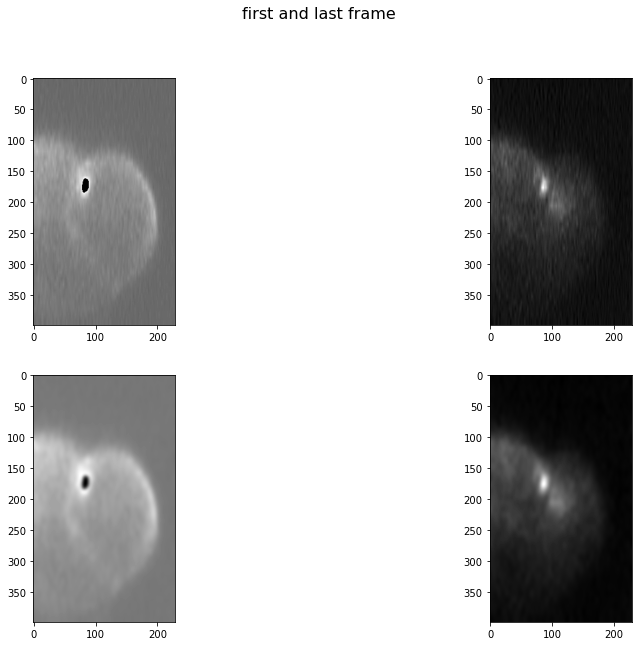

In [3]:
mpl.rcParams['figure.figsize'] = (15, 10)

fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(stack[0], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(stack[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(stack_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(stack_smooth[-1], plt.get_cmap('gray'))

In [4]:
max_rs = (stack[0].shape[1] / 2,
          stack[0].shape[1] / 2)

min_rs = (5,5)
print (min_rs, max_rs)

(5, 5) (114.5, 114.5)


# Adding ring

In [5]:
#specify number of segments and segmentation parameters
data = Data3d( stack_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=250,max_delta_k=1)
objects = []

In [6]:
ring = data.init_object("ring")
objects.append(ring)

In [7]:
cx = stack.shape[2] / 2
cy = stack.shape[1] / 2
data.add_object_at( ring, min_rs, max_rs, frame=0, seed=(cx,cy), segment_it=True )
data.track(ring, seed_frame=0, target_frames=range(0,len(data.images)), recenter_iterations=2)

Added appearance for "ring" in frame 0 with seed coordinates [114. 200.]
      Optimum energy:  6.6855481023630094
      Nodes in/out:  10358 7642
      Area:  14566.000000000007
Added appearance for "ring" in frame 0 with seed coordinates [114. 200.]
      Optimum energy:  6.6855481023630094
      Nodes in/out:  10358 7642
      Area:  14566.000000000007
    Updated center to [119 204]
    Updated center to [119 204]
Added appearance for "ring" in frame 1 with seed coordinates [119. 204.]
      Optimum energy:  5.906101326450424
      Nodes in/out:  10781 7219
      Area:  15505.000000000005
    Updated center to [122 207]
    Updated center to [122 207]
Added appearance for "ring" in frame 2 with seed coordinates [122. 207.]
      Optimum energy:  5.428715045738831
      Nodes in/out:  10946 7054
      Area:  15927.500000000005
    Updated center to [124 210]
    Updated center to [124 210]
Added appearance for "ring" in frame 3 with seed coordinates [124. 210.]
      Optimum energy:

      Optimum energy:  3.073710795154265
      Nodes in/out:  8607 9393
      Area:  10095.500000000002
    Updated center to [119 217]
    Updated center to [119 217]
Added appearance for "ring" in frame 34 with seed coordinates [119. 217.]
      Optimum energy:  2.9494646475696364
      Nodes in/out:  8590 9410
      Area:  10064.000000000002
    Updated center to [118 217]
    Updated center to [118 217]
Added appearance for "ring" in frame 35 with seed coordinates [118. 217.]
      Optimum energy:  2.657051058185261
      Nodes in/out:  8557 9443
      Area:  10010.0
    Updated center to [117 218]
    Updated center to [117 218]
Added appearance for "ring" in frame 36 with seed coordinates [117. 218.]
      Optimum energy:  2.897186379287256
      Nodes in/out:  7926 10074
      Area:  8698.499999999998
    Updated center to [118 219]
    Updated center to [118 219]
Added appearance for "ring" in frame 37 with seed coordinates [118. 219.]
      Optimum energy:  2.989837836949592
 

      Optimum energy:  1.9611218694606967
      Nodes in/out:  1242 16758
      Area:  495.49999999999983
    Updated center to [ 97 190]
    Updated center to [ 97 190]
Added appearance for "ring" in frame 69 with seed coordinates [ 97. 190.]
      Optimum energy:  1.9533105592204256
      Nodes in/out:  971 17029
      Area:  375.4999999999998
    Updated center to [ 95 188]
    Updated center to [ 95 188]
Added appearance for "ring" in frame 70 with seed coordinates [ 95. 188.]
      Optimum energy:  2.0601807480977303
      Nodes in/out:  1062 16938
      Area:  397.5000000000001
    Updated center to [ 95 187]
    Updated center to [ 95 187]
Added appearance for "ring" in frame 71 with seed coordinates [ 95. 187.]
      Optimum energy:  1.846696092975419
      Nodes in/out:  823 17177
      Area:  285.5
    Updated center to [ 94 186]
    Updated center to [ 94 186]
Added appearance for "ring" in frame 72 with seed coordinates [ 94. 186.]
      Optimum energy:  1.9878531549444323


In [8]:
# specify segmentation parameter
data.segment2dt( ring, max_radial_delta=5 )

Results for frame 0:
      Optimum energy:  248.173890077101
      Area:  15789.000000000004
Results for frame 1:
      Optimum energy:  248.173890077101
      Area:  15949.500000000002
Results for frame 2:
      Optimum energy:  248.173890077101
      Area:  16180.00000000001
Results for frame 3:
      Optimum energy:  248.173890077101
      Area:  16013.500000000004
Results for frame 4:
      Optimum energy:  248.173890077101
      Area:  16402.500000000004
Results for frame 5:
      Optimum energy:  248.173890077101
      Area:  16418.500000000004
Results for frame 6:
      Optimum energy:  248.173890077101
      Area:  16592.5
Results for frame 7:
      Optimum energy:  248.173890077101
      Area:  17191.000000000015
Results for frame 8:
      Optimum energy:  248.173890077101
      Area:  17188.500000000007
Results for frame 9:
      Optimum energy:  248.173890077101
      Area:  17375.00000000001
Results for frame 10:
      Optimum energy:  248.173890077101
      Area:  17389.00

# Check results

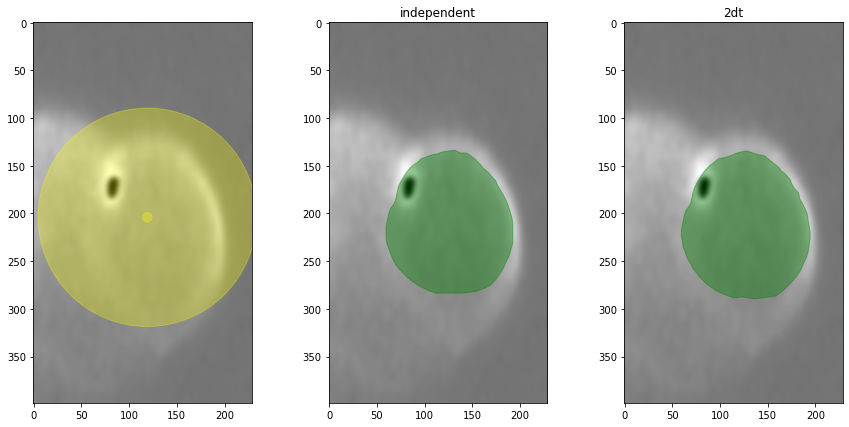

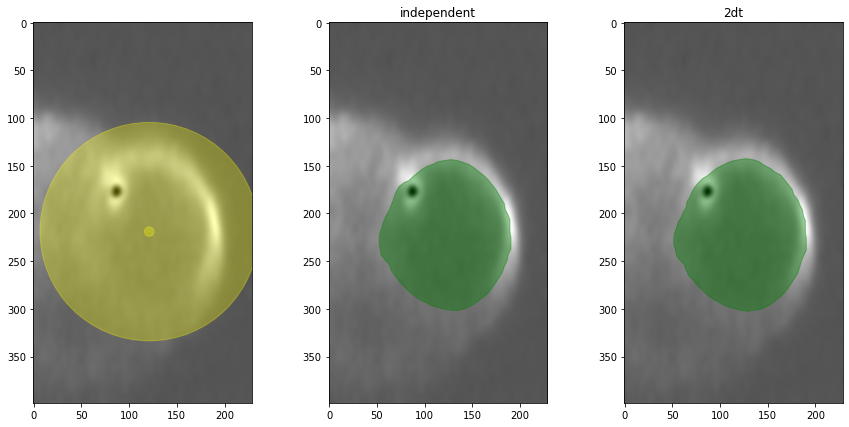

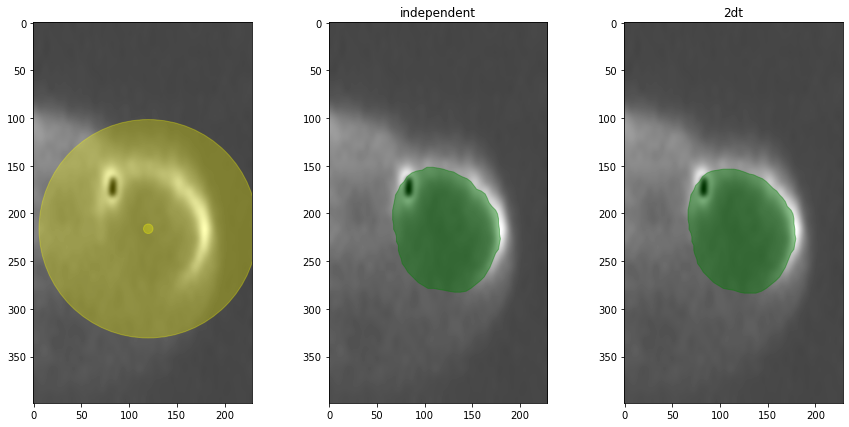

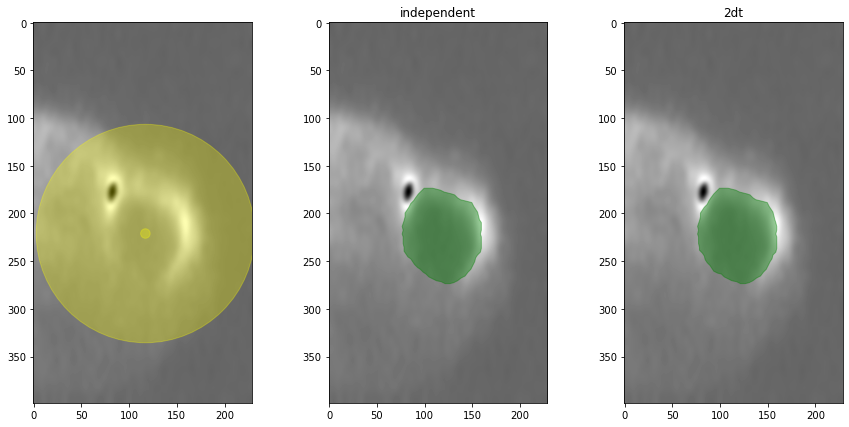

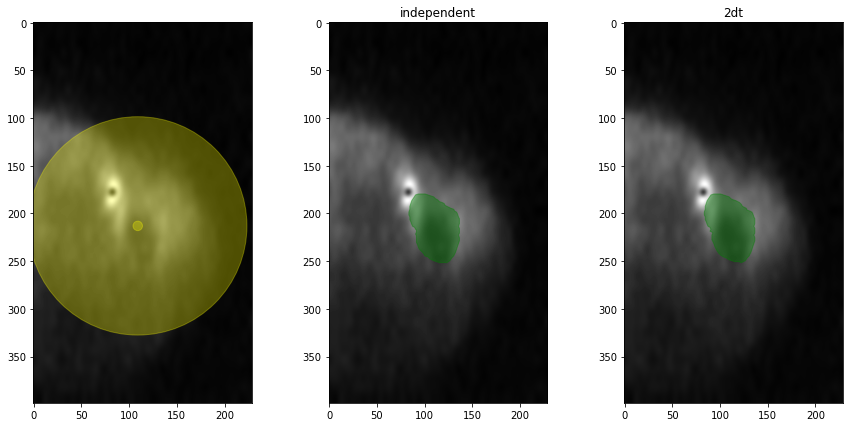

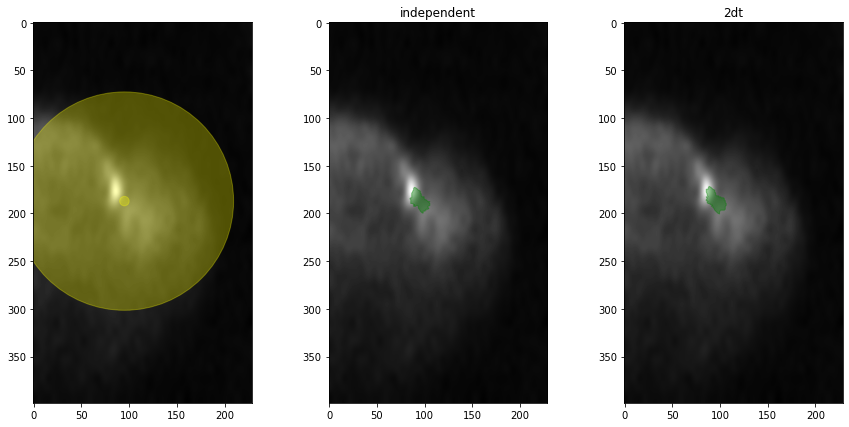

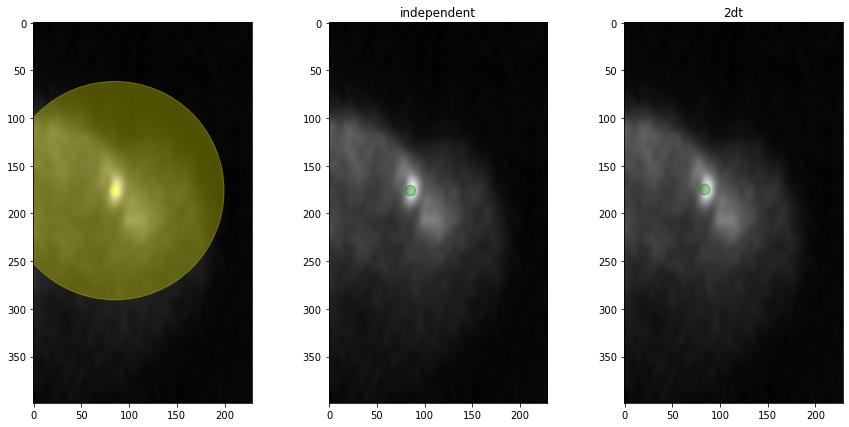

In [9]:
mpl.rcParams['figure.figsize'] = (15, 7)
for frame in range(1,int(len(data.images)),int(len(data.images))//6):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax )

# Create and show segmentation movie
_Note:_ this also creates the data you might want to export below... so you cannot skip this step if you are interested in doing so!

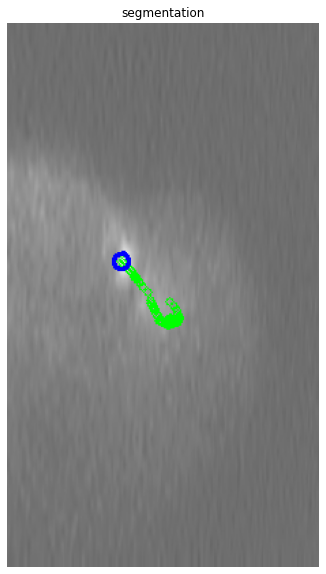

In [10]:

data = Data3d( stack_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=250,max_delta_k=1)
from moviemaker2d import MovieMaker2d
mm = MovieMaker2d(False)
frames, centers, all_polygones, radii = mm.draw_segmentation(data, stack, folder=None, inline=True)

### Store movie frames in a folder

In [11]:
# specify destination folder if not default
for f in range(len(frames)):
    imsave(folder+'movie_export/frame%02d.tif'%(f), frames[f])

In [12]:
## write output file

data_filename = folder+'movie_export/data.jug'

with open(data_filename, "w") as data_file:
    for t in range(len(frames)):
        data_file.write("t, %d\n"%t)
        data_file.write("c, %d, %d\n"%(centers[t][0],centers[t][1]))
        data_file.write("r, %d\n"%radii[t])
        polygone = all_polygones[t][0] # we will only export the first polygone here!
        for p in range(len(polygone)):
            #absolute point coordinates: 
              data_file.write("p%d, %d, %d\n"%(p,polygone[p][0],polygone[p][1]))
        data_file.write("\n")

In [15]:
import numpy as np
from scipy.interpolate import UnivariateSpline

from scipy.integrate import odeint
import copy

import matplotlib.pyplot as plt
from scipy.integrate import simps
from mpl_toolkits.mplot3d import Axes3D

import trimesh

from pyefd import elliptic_fourier_descriptors

import h5py

import csv

import xlsxwriter

import os

In [16]:
##Calculate fourier coefficent smoothed coordinates with temporal smoothing of fourier coefficents (using moving average)

##Assign variables
X = xy
X_theta = np.zeros(xy.shape[:2])

N = 1024
Nk = 3
theta = np.linspace(0., 2 * np.pi, 72)



X = xy
X_theta = np.zeros(xy.shape[:2])

for k in range(X.shape[0]):
    xy_ = X[k]
    m = np.mean(xy_, axis=0)

    X_theta[k] = np.arctan2(xy_[:, 1] - m[1], xy_[:, 0] - m[0])

t = np.array(range(X.shape[0])) * 2.7
n_frames = len(t)


def solve_harmonic_series(x, theta, N=3):
    A = []

    for t in theta:
        _ = []
        _.append(1.)

        for ix in range(1, N + 1):
            _.append(np.cos(t * ix))

        for ix in range(1, N + 1):
            _.append(np.sin(t * ix))

        # print _
        A.append(np.array(_))

    A = np.array(A)
    B = x.T

    co = np.linalg.lstsq(A, B)[0]

    return co


co = []
xy_outS = []
xy_real = []
x_outS = []
y_outS = []

for k in range(len(X)):
    xy_ = X[k]
    theta_ = X_theta[k]

    ix = list(set([np.argmin(np.abs(theta_ - u)) for u in np.linspace(-np.pi, np.pi, N)]))

    x_co = solve_harmonic_series(xy_[ix, 0], theta_[ix], N=Nk)
    y_co = solve_harmonic_series(xy_[ix, 1], theta_[ix], N=Nk)

    xy_real.append(xy_[ix])

    co.append(np.vstack([x_co, y_co]))

co = np.array(co)
xy_real = np.array(xy_real)


#define moving average function
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

#temperal smoothing of x and y coordinates using moving average of 5 timepoints
l=len(co)-4 #length of new moving average array to remove incomplete moving average calculations
coS = co[0:l,:,:] #set new shorter co array 
co_f = dict()
co_f['x'] = []
co_f['y'] = []

for k in range(co.shape[-1]):
    # x
    f = moving_average(co[:, 0, k], 5)
    # replace
    coS[:, 0, k] = f
    co_f['x'].append(f)

    # y
    f = moving_average(co[:, 1, k], 5)
    # replace
    coS[:, 1, k] = f
    co_f['y'].append(f)
#     coS.append(np.vstack([fx, fy]))

def compute_harmonic(theta, co, N=3):
    A = []

    for t in theta:
        _ = []
        _.append(1.)

        for ix in range(1, N + 1):
            _.append(np.cos(t * ix))

        for ix in range(1, N + 1):
            _.append(np.sin(t * ix))

        # print _
        A.append(np.array(_))

    A = np.array(A)

    return A.dot(co)

x_norm = []

norm_y = np.sqrt(co[:, 1, 2] ** 2 + co[:, 1, 1] ** 2)
phase_y = np.arctan2(co[:, 1, 2], co[:, 1, 1])

norm_x = np.sqrt(co[:, 0, 2] ** 2 + co[:, 0, 1] ** 2)
phase_x = np.arctan2(co[:, 0, 2], co[:, 0, 1])

for k in range(len(X)):
    x_co = co[k, 0, :]
    y_co = co[k, 1, :]

    x_new = compute_harmonic(theta, x_co, N=Nk)
    y_new = compute_harmonic(theta, y_co, N=Nk)

    
    x_outS.append(np.array([x_new]).T)
    y_outS.append(np.array([y_new]).T)
    xy_outS.append(np.array([x_new, y_new]).T)

xy_outS = np.array(xy_outS, dtype=np.float32)
x_outS = np.array(x_outS, dtype=np.float32)
y_outS = np.array(y_outS, dtype=np.float32)




<ipython-input-16-56681869f39e>:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  co = np.linalg.lstsq(A, B)[0]
<ipython-input-16-56681869f39e>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xy_real = np.array(xy_real)


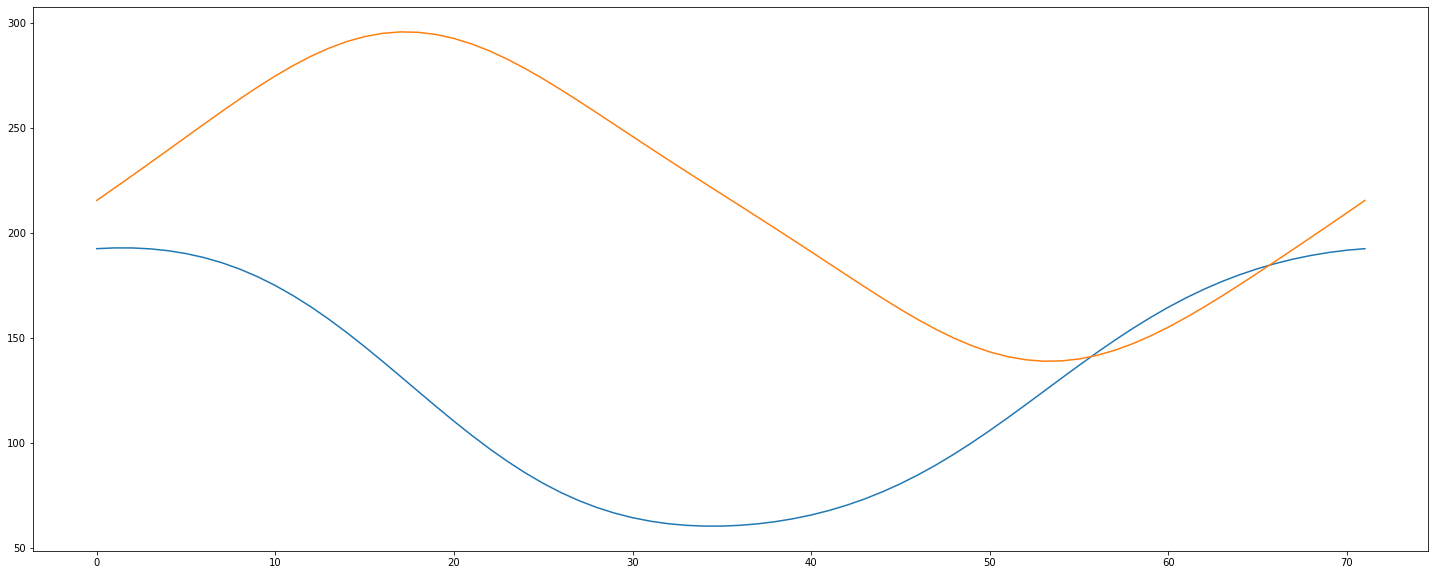

86


In [17]:
# (optional) test xy_output

plt.plot(xy_outS[1])
plt.show()

l=len(xy_outS)
print(l)

In [18]:
## Save x and y coodinate matrices to separated excel sheets in the same workbook
#specify destination filepath
workbook = xlsxwriter.Workbook('filepath')
worksheet = workbook.add_worksheet()

row = 0

for col, data in enumerate(x_outS):
    worksheet.write_column(row, col, data)
    
worksheet = workbook.add_worksheet()
row = 0

for col, data in enumerate(y_outS):
    worksheet.write_column(row, col, data)    
    
workbook.close()

In [19]:
##Compute speed from coefficient smoothed coordinates in cluding time smoothing using differentiator function
def differentiator(f, N=7):
    if N == 7:
        ret = []
        for k in range(3, len(f) - 3):
            ret.append((39 * (f[k + 1] - f[k - 1]) + 12 * (f[k + 2] - f[k - 2]) - 5 * (f[k + 3] - f[k - 3])) / (96))

        return ret
    elif N == 11:
        ret = []
        for k in range(5, len(f) - 5):
            ret.append((322 * (f[k + 1] - f[k - 1]) + 256 * (f[k + 2] - f[k - 2]) + 39 * (f[k + 3] - f[k - 3]) - 32 * (
                        f[k + 4] - f[k - 4]) - 11 * (f[k + 5] - f[k - 5])) / (1536))

        return ret


        # let's look at speed as estimated by a differentiator
dx = np.array(differentiator(xy_outS[:, :, 0]))
dy = np.array(differentiator(xy_outS[:, :, 1]))

dxAcc = np.array(differentiator(dx[:, :]))
dyAcc = np.array(differentiator(dy[:, :]))

speedS = np.sqrt(dx ** 2 + dy ** 2)
speedSAcc = np.sqrt(dxAcc ** 2 + dyAcc ** 2)

print(speedS)

[[0.9299105  0.94626844 0.96138155 ... 0.8906605  0.9116444  0.9299105 ]
 [0.4796914  0.50161403 0.52574694 ... 0.44188103 0.459952   0.4796914 ]
 [0.4268382  0.4657429  0.5058523  ... 0.3572567  0.39034978 0.4268382 ]
 ...
 [1.2031846  1.2031143  1.2029412  ... 1.2030538  1.203162   1.2031846 ]
 [0.06291601 0.06324725 0.06322614 ... 0.06138516 0.06226793 0.06291601]
 [0.06148659 0.06122856 0.06072993 ... 0.06098343 0.06141797 0.06148659]]


In [20]:
## Save speed data from differentiator calculations of spatial and temporaly smoothed x and y coordinates
#specify destination file path
workbook = xlsxwriter.Workbook('filepath')

worksheet = workbook.add_worksheet()

row = 0

for col, data in enumerate(speedS):
    worksheet.write_column(row, col, data)
        
    
workbook.close()

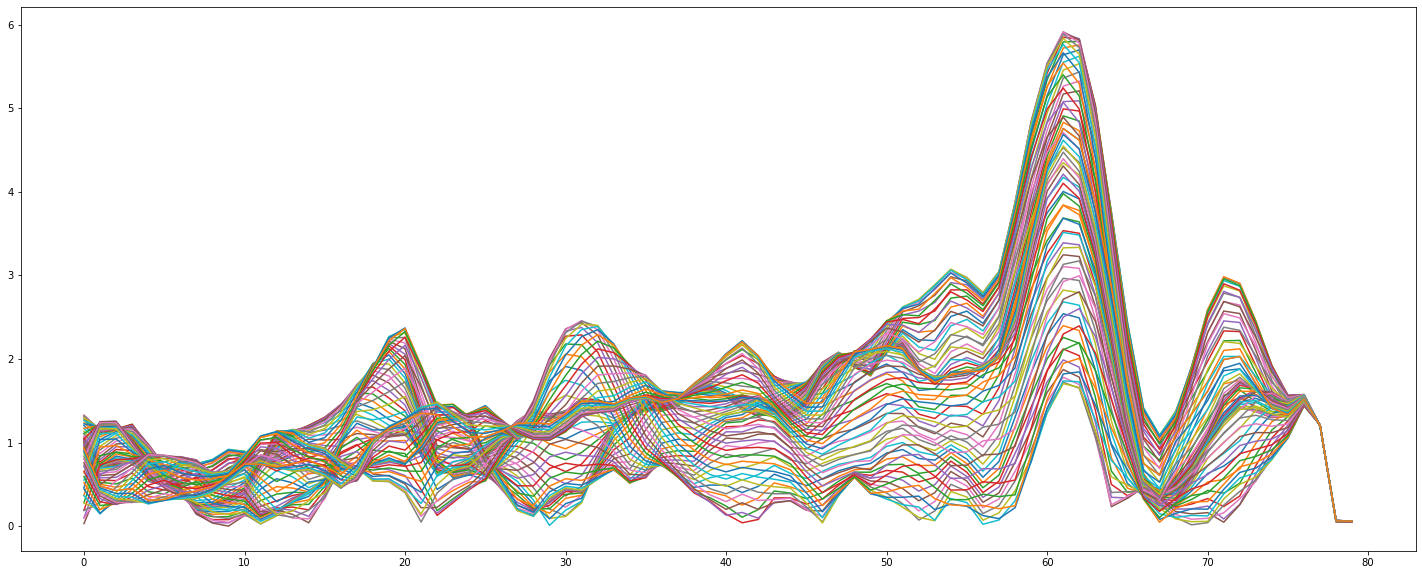

In [21]:
## plot smoothed data
plt.plot(speedS)
plt.show()